In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [4]:
df = pd.read_csv("data/imagem1.txt", delim_whitespace=True, header=None)
df.columns = ['y', 'x', 'label', 'ndai', 'sd', 'corr', 'ra_df', 'ra_cf', 'ra_bf', 'ra_af', 'ra_an']

<AxesSubplot:xlabel='None-x', ylabel='y'>

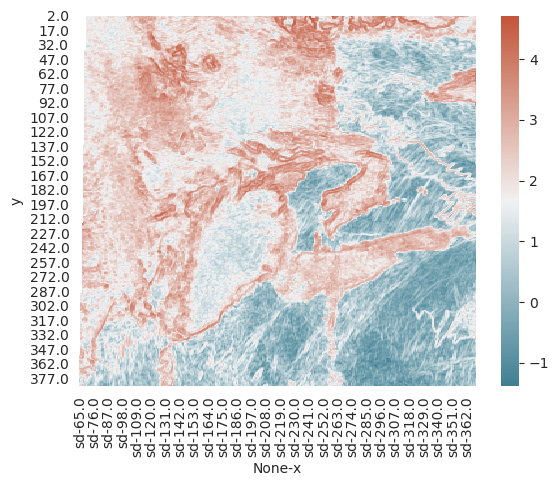

In [44]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(np.log(df[['y', 'x', 'sd']].set_index(['y', 'x']).unstack()), cmap=cmap)

<AxesSubplot:xlabel='None-x', ylabel='y'>

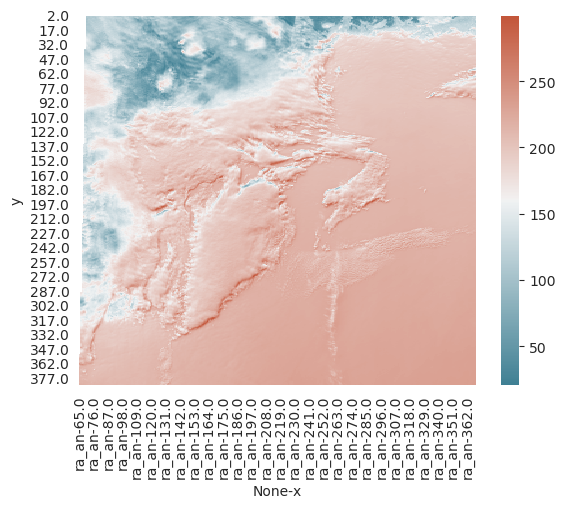

In [45]:
sns.heatmap(df[['y', 'x', 'ra_an']].set_index(['y', 'x']).unstack(), cmap=cmap)